In [ ]:
! pip install chainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from subprocess import check_output
import time
import math
import random
import copy
import torch
from sklearn.utils import shuffle
import chainer
import chainer.functions as F
import chainer.links as L
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl
init_notebook_mode(connected=True)

Dataset

In [10]:
df = pd.read_csv('/content/PL11_data_all_En.csv')
df.head()

,Cycles,Capacity,PerEn3
0,6,1.4393,1.8572
1,11,1.4360,1.8107
2,16,1.4335,1.7562
3,21,1.4314,1.7692
4,26,1.4282,1.8305


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Cycles    133 non-null    int64  
 1   Capacity  133 non-null    float64
 2   PerEn3    133 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 3.2 KB


In [11]:
df.drop({'Cycles'},axis=1,inplace=True)
#data = shuffle(df)
train = df[:119]
test = df[119:]

Environmet

In [34]:
class Environment1:
    
    def __init__(self, data, history_t=10):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act:         0: Charge,     1: No Charge
        if act == 0:
            self.positions.append(self.data.iloc[self.t, :]['Capacity'])
        elif act == 1: 
             profits = 0
             for p in self.positions:
               profits += (self.data.iloc[self.t, :]['Capacity'] - p)
             reward += profits
             self.profits += profits
             self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Capacity'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Capacity'] - self.data.iloc[(self.t-1), :]['Capacity'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [50]:
class Environment2:
    
    def __init__(self, newdf,history_t=0):

        self.history_t = history_t
        self.data = train
        self.n_samples = train.shape[0]
        self.capacity =  torch.FloatTensor(train['Capacity'].values)
        self.states = torch.FloatTensor(train['PerEn3'].values)
        self.observation_space = torch.FloatTensor(train['PerEn3'].values) #.reshape(100,1)
        self.action_space = torch.FloatTensor(train['Capacity'].values)
        self.idx = 0
    
    def reset(self):
        self.idx = 0
        return self.states[self.idx].view(1, -1)
    
    def step(self, action):
      
        #profits = action/(df.iloc[0]['Capacity'])

        if action > 0.9:
          #print('Charge')
          reward = 1
        else:
          reward = 0
          #print('No Charge')

        self.idx += 1

        if self.idx >= self.n_samples:
            done = True
            self.idx = 0
        else:
            done = False

        return self.states[self.idx].view(1, -1), reward, done

env = Environment2(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

tensor([[1.8572]])
(tensor([[1.8107]]), 0, False)
(tensor([[1.7562]]), 1, False)
(tensor([[1.7692]]), 1, False)


Model

In [38]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.PReLU(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size),
                fc4 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            h = F.relu(self.fc3(h))
            y = self.fc4(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=2)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 150
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            pact = np.random.choice(train['Capacity'])/df['Capacity'][0]
            if pact > 0.9:
              pact = 1
            else:
              pact = 0

            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            obs, reward, done = env.step(pact)

            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            #print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            print('Epoch:{}     step:{}     reward:{}     loss:{}'.format(epoch+1,total_step,log_reward,log_loss))
            start = time.time()
            
    return Q, total_losses, total_rewards, target, q
    

Training Using Environmet1

In [39]:
Q, total_losses, total_rewards, target, q = train_dqn(Environment1(train))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch:5     step:590     reward:-15.8     loss:5.838264934252948
Epoch:10     step:1180     reward:-8.8     loss:6.487370453774929
Epoch:15     step:1770     reward:-2.6     loss:2.525874413951533
Epoch:20     step:2360     reward:-0.4     loss:3.5397940570488573
Epoch:25     step:2950     reward:0.0     loss:5.279521856736392
Epoch:30     step:3540     reward:1.2     loss:4.310726492013782
Epoch:35     step:4130     reward:1.2     loss:6.463789849728346
Epoch:40     step:4720     reward:0.0     loss:6.825248253252357
Epoch:45     step:5310     reward:0.8     loss:5.3317494340706615
Epoch:50     step:5900     reward:0.8     loss:4.752085270918906
Epoch:55     step:6490     reward:-0.8     loss:4.77190597676672
Epoch:60     step:7080     reward:2.6     loss:4.4482532070018355
Epoch:65     step:7670     reward:1.2     loss:7.254226598143577
Epoch:70     step:8260     reward:2.2     loss:5.348932468425483
Epoch:75     step:8850     reward:2.6     loss:8.17777511496097
Epoch:80     step:94

In [ ]:
def plot_loss_reward(total_losses, total_rewards):

    fig,axes = plt.subplots(nrows=1,ncols=2,figsize = (12,6))
    axes[0].plot(total_rewards)
    axes[0].set_title('Reward Function')
    axes[0].set_ylim([-5, np.max([total_rewards,total_losses])+5])
    axes[1].plot(total_losses)
    axes[1].set_title('Loss Function')
    axes[1].set_ylim([-5, np.max([total_rewards,total_losses])+5])

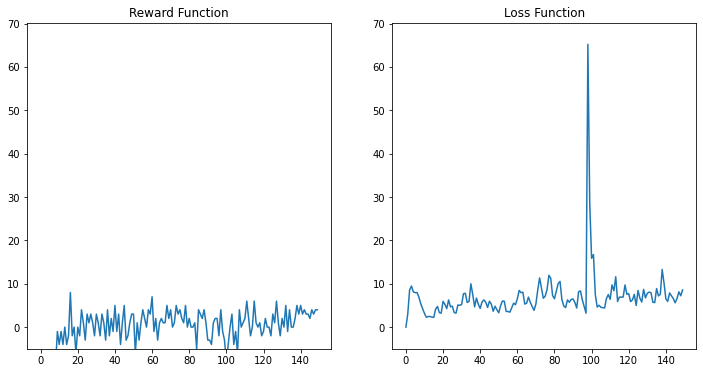

In [40]:
plot_loss_reward(total_losses, total_rewards)

In [ ]:
from sklearn import metrics
q = chainer.as_array(q)
print('MAE : ' , metrics.mean_absolute_error(target,q))
print('MSE : ' , metrics.mean_squared_error(target,q))
print('RMSE : ' , np.sqrt(metrics.mean_squared_error(target,q)))

MAE :  0.057963036
MSE :  0.008819903
RMSE :  0.09391434


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



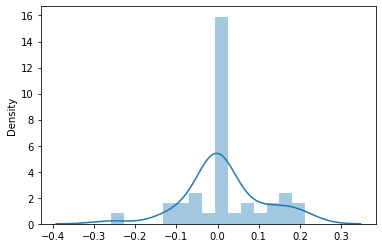

In [ ]:
sns.distplot((target-q))

Training Using Environment2

In [44]:
Q, total_losses, total_rewards, target, q = train_dqn(Environment2(train))

Epoch:5     step:590     reward:100.2     loss:10.933860293403267
Epoch:10     step:1180     reward:109.8     loss:21.873929599672557
Epoch:15     step:1770     reward:116.4     loss:34.610686214268206
Epoch:20     step:2360     reward:116.4     loss:39.060510942339896
Epoch:25     step:2950     reward:114.4     loss:39.71116125434637
Epoch:30     step:3540     reward:115.6     loss:38.105012859404084
Epoch:35     step:4130     reward:116.2     loss:36.409357541799544
Epoch:40     step:4720     reward:116.6     loss:35.6554312825203
Epoch:45     step:5310     reward:114.4     loss:34.22651859372854
Epoch:50     step:5900     reward:115.6     loss:33.16260814964771
Epoch:55     step:6490     reward:115.0     loss:30.9299849614501
Epoch:60     step:7080     reward:115.0     loss:29.164472806453706
Epoch:65     step:7670     reward:114.8     loss:26.64288858920336
Epoch:70     step:8260     reward:115.8     loss:27.039357182383537
Epoch:75     step:8850     reward:114.4     loss:26.505123

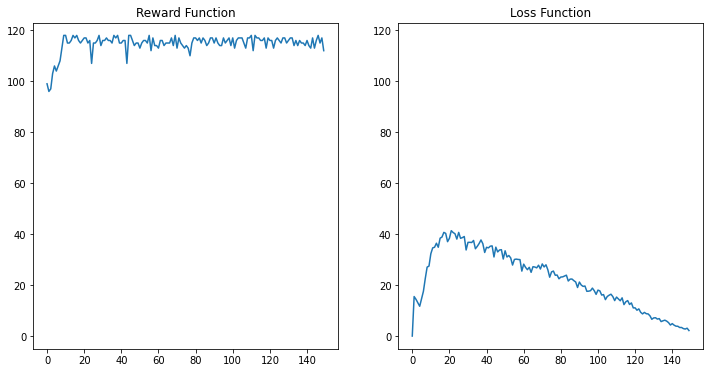

In [45]:
plot_loss_reward(total_losses, total_rewards)

In [46]:
from sklearn import metrics
q = chainer.as_array(q)
print('MAE : ' , metrics.mean_absolute_error(target,q))
print('MSE : ' , metrics.mean_squared_error(target,q))
print('RMSE : ' , np.sqrt(metrics.mean_squared_error(target,q)))

MAE :  0.076332375
MSE :  0.018226696
RMSE :  0.13500628


In [48]:
q

array([[32.706966, 33.75834 ],
       [32.16081 , 33.39264 ],
       [32.02316 , 33.30047 ],
       [32.230747, 33.439465],
       [31.785046, 33.141033],
       [32.433887, 33.575485],
       [32.565437, 33.663567],
       [31.785046, 33.141033],
       [32.75304 , 33.789177],
       [31.940456, 33.245094],
       [32.618717, 33.69924 ],
       [32.62926 , 33.706303],
       [32.608723, 33.692554],
       [31.94434 , 33.247696],
       [32.171356, 33.399696],
       [32.16081 , 33.392635],
       [32.073666, 33.33429 ],
       [32.240177, 33.445786],
       [32.240177, 33.445786],
       [31.872742, 33.199753]], dtype=float32)

In [47]:
target

array([[32.719296, 33.75834 ],
       [32.379852, 33.39264 ],
       [32.02316 , 33.308865],
       [32.230747, 33.153194],
       [31.785046, 33.405437],
       [32.433887, 33.502007],
       [32.565437, 33.794243],
       [31.785046, 33.405437],
       [32.75304 , 33.69479 ],
       [31.940456, 33.19968 ],
       [32.618717, 33.66993 ],
       [32.62926 , 33.410843],
       [32.608723, 33.6375  ],
       [31.94434 , 33.632816],
       [32.171356, 33.403996],
       [32.16081 , 33.347065],
       [32.073666, 33.50561 ],
       [32.240177, 33.25409 ],
       [32.240177, 33.25409 ],
       [31.872742, 33.484715]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



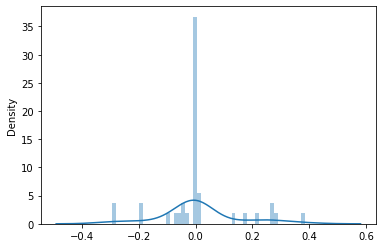

In [49]:
sns.distplot((target-q))

In [55]:
class Environment:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0
        
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Capacity'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Capacity'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Capacity'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Capacity'] - self.data.iloc[(self.t-1), :]['Capacity'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0033000000000000806], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, -0.0033000000000000806, -0.0024999999999999467], 0, False)
([-0.0020999999999999908, 0, 0, 0, 0, 0, 0, 0, -0.0033000000000000806, -0.0024999999999999467, -0.0020999999999999908], 0, False)


In [56]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            #print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            print('Epoch:{}     step:{}     reward:{}     loss:{}'.format(epoch+1,total_step,log_reward,log_loss))
            start = time.time()
            
    return Q, total_losses, total_rewards, q, target

In [62]:
Q, total_losses, total_rewards, q, target = train_dqn(Environment(train))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Epoch:5     step:590     reward:-25.0     loss:2.527540372960266
Epoch:10     step:1180     reward:-8.6     loss:0.6708818232507838
Epoch:15     step:1770     reward:-3.4     loss:0.4626120684137277
Epoch:20     step:2360     reward:-0.4     loss:0.542225997929927
Epoch:25     step:2950     reward:-0.4     loss:0.5885289530735462
Epoch:30     step:3540     reward:0.4     loss:0.6451941282488406
Epoch:35     step:4130     reward:-1.6     loss:0.899194591655396
Epoch:40     step:4720     reward:-2.6     loss:0.8555329843075015
Epoch:45     step:5310     reward:-1.8     loss:0.4742641825170722
Epoch:50     step:5900     reward:-0.2     loss:0.2961501326499274


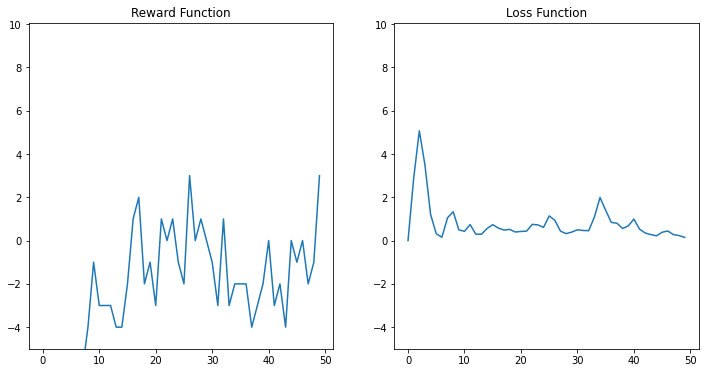

In [63]:
plot_loss_reward(total_losses, total_rewards)

In [66]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    
    # train
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []

    for _ in range(len(train_env.data)-1):
        
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)
            
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs
        
    train_profits = train_env.profits
    
    # test
    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)
            
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs
        
    test_profits = test_env.profits
    
    # plot
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    #train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    #test2 = test_copy[test_copy['act'] == 2]
    act_color0, act_color1, act_color2 = 'gray', 'cyan', 'magenta'

    data = [
        Candlestick(x=train0.index,  capacity=train0['Capacity'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=train1.index,  capacity=train1['Capacity'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=train2.index,  capacity=train2['Capacity'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2))),
        Candlestick(x=test0.index,   capacity=test0['Capacity'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=test1.index,   capacity=test1['Capacity'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=test2.index,   capacity=test2['Capacity'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]
    title = '{}: train s-reward {}, profits {}, test s-reward {}, profits {}'.format(
        algorithm_name,
        int(sum(train_rewards)),
        int(train_profits),
        int(sum(test_rewards)),
        int(test_profits)
    )
    layout = {
        'title': title,
        'showlegend': False,
         'shapes': [
             {'x0': date_split, 'x1': date_split, 'y0': 0, 'y1': 1, 'xref': 'x', 'yref': 'paper', 'line': {'color': 'rgb(0,0,0)', 'width': 1}}
         ],
        'annotations': [
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'left', 'text': ' test data'},
            {'x': date_split, 'y': 1.0, 'xref': 'x', 'yref': 'paper', 'showarrow': False, 'xanchor': 'right', 'text': 'train data '}
        ]
    }
    figure = Figure(data=data, layout=layout)
    #iplot(figure)

In [70]:
train_env, test_env, Q, algorithm_name = Environment(train), Environment(test), Q, 'DQN'

In [72]:
# train
pobs = train_env.reset()
train_acts = []
train_rewards = []

for _ in range(len(train_env.data)-1):
        
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)
            
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs
        
train_profits = train_env.profits
    
# test
pobs = test_env.reset()
test_acts = []
test_rewards = []

In [73]:
for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)
            
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs
        
test_profits = test_env.profits
    
# plot
train_copy = train_env.data.copy()
test_copy = test_env.data.copy()
train_copy['act'] = train_acts + [np.nan]
train_copy['reward'] = train_rewards + [np.nan]
test_copy['act'] = test_acts + [np.nan]
test_copy['reward'] = test_rewards + [np.nan]
train0 = train_copy[train_copy['act'] == 0]
train1 = train_copy[train_copy['act'] == 1]
#train2 = train_copy[train_copy['act'] == 2]
test0 = test_copy[test_copy['act'] == 0]
test1 = test_copy[test_copy['act'] == 1]
#test2 = test_copy[test_copy['act'] == 2]
act_color0, act_color1, act_color2 = 'gray', 'cyan', 'magenta'

In [82]:
Candlestick(train0)

ValueError: ignored

In [ ]:
data = [
        Candlestick(x=train0.index,  capacity=train0['Capacity'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=train1.index,  capacity=train1['Capacity'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=train2.index,  capacity=train2['Capacity'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2))),
        Candlestick(x=test0.index,   capacity=test0['Capacity'], increasing=dict(line=dict(color=act_color0)), decreasing=dict(line=dict(color=act_color0))),
        Candlestick(x=test1.index,   capacity=test1['Capacity'], increasing=dict(line=dict(color=act_color1)), decreasing=dict(line=dict(color=act_color1))),
        Candlestick(x=test2.index,   capacity=test2['Capacity'], increasing=dict(line=dict(color=act_color2)), decreasing=dict(line=dict(color=act_color2)))
    ]

In [ ]:
plot_train_test_by_q(Environment(train), Environment(test), Q, 'DQN')

In [94]:
df['Capacity']

0      1.4393
1      1.4360
2      1.4335
3      1.4314
4      1.4282
        ...  
128    1.2399
129    1.2355
130    1.2303
131    1.2284
132    1.2263
Name: Capacity, Length: 133, dtype: float64